In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Crear datasets
from sklearn.datasets import make_regression

Vamos a crear un dataset sintetico utilizando las librerias de [Sklearn Datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), en particular nos interesa crear un problema de regresion
lineal al que podemos variarle sus parametros

In [3]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [4]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


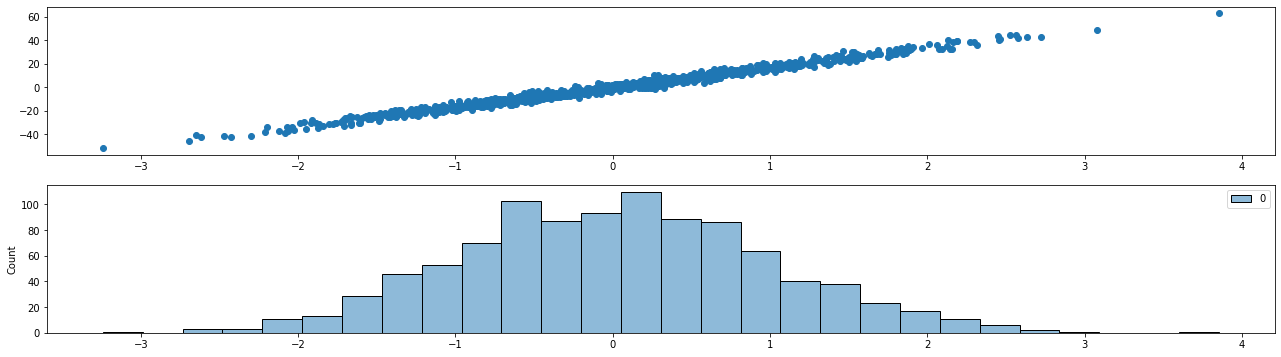

In [5]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1]);

## Funciones auxiliares para generar datos anómalos

In [6]:
def generate_nulls(df: pd.DataFrame,
                   cols: list = None,
                   percentage: float = 0.05) -> pd.DataFrame:
  """Con esta función vamos a poder generar nulos en ciertas columnas de nuestro
  dataset.
  """  
  cols = df.columns.tolist() if cols is None else cols
  seeds = np.random.randint(100, size = len(cols))
  
  nsamples = np.math.floor(len(df) * percentage)

  result = df.copy(deep = True)
  for i,col_name in enumerate(cols):
      np.random.seed(seeds[i])
      
      idx_to_remove = result[col_name].sample(n = nsamples).index
      result[col_name].iloc[idx_to_remove] = np.nan if result[col_name].dtype in [int,float] else None
  
  return result

def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    if extreme_outlier:
      iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)
      max_val = 3*iqr
      outlier_sign = [1 if np.random.random() < 0.5 else -1 for _ in range(nsamples)]
      outliers = np.multiply(outlier_sign, np.random.uniform(low = iqr,
                                                          high = max_val,
                                                          size = nsamples))
      
      result[col_name].loc[idx_to_change] = outliers
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].iloc[idx_to_change] = samples
  return result

In [7]:
df_outlier = generate_outliers(df,['target'], percentage = 0.01, extreme_outlier = True)

<AxesSubplot:xlabel='feature_1', ylabel='target'>

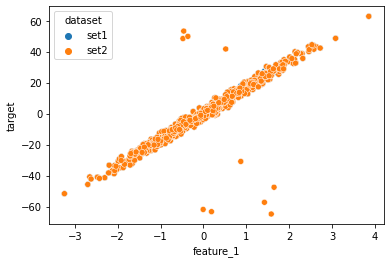

In [8]:
sns.scatterplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

In [9]:
columnas_a_modificar = ['feature_1'] 
df_missing = generate_nulls(df,columnas_a_modificar, percentage = 0.01)

In [10]:
df_missing.isna().sum()

feature_1    10
target        0
dtype: int64

# Primera Parte

## Ejercicio 1

Crear una función que separe los datos en train-validation-test 70-20-10


Hints: 

* Usar Indexing y slicing
* Usar np.random.[...]

In [13]:
def split(df: pd.DataFrame, train_size: float, val_size: float, test_size: float, target_index: int): #suponiendo que nuestro target es solo una columna



    from sklearn.model_selection import train_test_split

    new_col = []
    features = []
    i = 0
    for col in df.columns:
        if i ==  target_index:
            new_col.append("target")
        else :
            new_col.append("feature_" + str(i+1))
            features.append("feature_" + str(i+1))
        i += 1
        
    df.columns = new_col

    X_train, X_test, Y_train, Y_test = train_test_split(df[features],
                                                        df["target"],
                                                        train_size = train_size)
    if val_size > 0:
        X_val, X_test, Y_val, Y_test = train_test_split(X_test,
                                                        Y_test,
                                                        train_size = val_size/(val_size+test_size))

        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    return X_train, X_test, Y_train, Y_test

In [14]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split(df, 0.7, 0.2, 0.1, 1)

print(len(X_train))
print(len(X_val))
print(len(X_test))

700
200
100


## Ejercicio 2

Utilizando la funcion `generate_nulls`. Insertar en la columna de features un 5% de valores nulos. Con esto, generar una función que les permita rellenar estos valores con la mediana, y otro con la media.

Compare los __scores__ obtenidos en las regresiones cuando tiene el dataset completo, y con los dos métodos de imputación. ¿Cambian mucho?

In [15]:
df.feature_1.median()

0.025300612234888248

In [17]:
df_con_ceros = generate_nulls(df, ["feature_1"], 0.05)
nan_rows = df_con_ceros[df_con_ceros.isna().any(1)]
print(df[df_con_ceros.isna().any(1)]["feature_1"])

9      1.066675
38    -1.424748
51    -0.459361
80     1.237816
83     0.254421
102   -0.034988
112    0.865755
155    0.629629
156    0.024510
162    0.208864
169   -0.981509
173    0.751933
198   -1.057711
205    2.720169
219    0.690144
220   -1.024388
223   -1.703382
230   -0.990536
232    1.158596
260    0.491919
279   -1.412304
299   -1.222128
324   -0.883857
328   -0.310267
334   -0.839218
446   -1.012104
464    0.650201
497   -0.393339
514    1.032465
527    0.224092
585   -0.003603
590    0.632408
602    0.478980
635   -1.435862
641    1.754794
643    0.223884
657   -0.219101
660   -0.985726
689    1.632411
698    0.058209
703   -1.889541
717    1.188393
755    0.472597
761   -1.702584
785   -1.125489
857    1.126565
863    0.271579
894    0.686051
962   -1.070892
972    0.177701
Name: feature_1, dtype: float64


In [18]:
print(df_con_ceros.isna().sum())
print("nueva mediana = {}".format(df_con_ceros.feature_1.median()))

feature_1    50
target        0
dtype: int64
nueva mediana = 0.019718887349076106


In [20]:
df_con_mediana = df_con_ceros.copy(deep=True)
df_con_mediana['feature_1'] = df_con_ceros['feature_1'].replace(np.nan, df_con_ceros.feature_1.median())
print(df_con_mediana.isna().sum())
print("nueva mediana = {}".format(df_con_mediana.feature_1.median()))

feature_1    0
target       0
dtype: int64
nueva mediana = 0.019718887349076106


In [21]:
(df[df_con_ceros.isna().any(1)]["feature_1"] - df_con_mediana[df_con_ceros.isna().any(1)]["feature_1"])/df[df_con_ceros.isna().any(1)]["feature_1"]

9      0.981514
38     1.013840
51     1.042927
80     0.984070
83     0.922495
102    1.563582
112    0.977223
155    0.968682
156    0.195482
162    0.905590
169    1.020090
173    0.973776
198    1.018643
205    0.992751
219    0.971428
220    1.019249
223    1.011576
230    1.019907
232    0.982980
260    0.959914
279    1.013962
299    1.016135
324    1.022310
328    1.063555
334    1.023497
446    1.019483
464    0.969673
497    1.050132
514    0.980901
527    0.912006
585    6.473608
590    0.968819
602    0.958831
635    1.013733
641    0.988763
643    0.911924
657    1.089999
660    1.020004
689    0.987920
698    0.661238
703    1.010436
717    0.983407
755    0.958276
761    1.011582
785    1.017520
857    0.982496
863    0.927392
894    0.971257
962    1.018414
972    0.889033
Name: feature_1, dtype: float64

In [22]:
df_con_media = df_con_ceros.copy(deep=True)
df_con_media['feature_1'] = df_con_ceros['feature_1'].replace(np.nan, df_con_ceros.feature_1.mean())

print(df_con_media.isna().sum())
print("nueva media = {}".format(df_con_media.feature_1.mean()))

feature_1    0
target       0
dtype: int64
nueva media = 0.021898874268597386


In [23]:
(df[df_con_ceros.isna().any(1)]["feature_1"]-df_con_media[df_con_ceros.isna().any(1)]["feature_1"])/df[df_con_ceros.isna().any(1)]["feature_1"]

9      0.979470
38     1.015370
51     1.047672
80     0.982308
83     0.913927
102    1.625888
112    0.974705
155    0.965219
156    0.106539
162    0.895152
169    1.022311
173    0.970877
198    1.020704
205    0.991949
219    0.968269
220    1.021378
223    1.012856
230    1.022108
232    0.981099
260    0.955483
279    1.015506
299    1.017919
324    1.024776
328    1.070581
334    1.026094
446    1.021637
464    0.966320
497    1.055674
514    0.978790
527    0.902278
585    7.078733
590    0.965372
602    0.954280
635    1.015251
641    0.987521
643    0.902187
657    1.099949
660    1.022216
689    0.986585
698    0.623787
703    1.011590
717    0.981573
755    0.953663
761    1.012862
785    1.019457
857    0.980561
863    0.919365
894    0.968080
962    1.020449
972    0.876766
Name: feature_1, dtype: float64

In [24]:
print("mediana original: {} \nmediana rellenando nan con mediana: {} \nmediana rellenando nan con media: {}".format(df.feature_1.median(),df_con_mediana.feature_1.median(),df_con_media.feature_1.median()))
print("\nmedia original: {} \nmedia rellenando nan con mediana: {} \nmedia rellenando nan con media: {}".format(df.feature_1.mean(),df_con_mediana.feature_1.mean(),df_con_media.feature_1.mean()))

mediana original: 0.025300612234888248 
mediana rellenando nan con mediana: 0.019718887349076106 
mediana rellenando nan con media: 0.0218988742685974

media original: 0.01933205582232549 
media rellenando nan con mediana: 0.021789874922621313 
media rellenando nan con media: 0.021898874268597386


Conclusión: para este df rellenar con la media podría ser una mejor aproximación dado que las nuevas media y mediana se encuentran más cerca de las originales en comparación con rellenar los NaN con la mediana

In [25]:
def mean_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
    df_con_media = df.copy(deep=True)
    df_con_media[columns] = df[columns].replace(np.nan, df[columns].mean())
    return df_con_media
    

In [26]:
nuevodf = mean_imputer(df_con_ceros, "feature_1") 
nuevodf

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314
...,...,...
995,-1.918771,-30.210145
996,0.482472,9.182647
997,0.241962,4.855134
998,1.366874,25.785771


In [27]:
def median_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
    df_con_mediana = df.copy(deep=True)
    df_con_mediana[columns] = df[columns].replace(np.nan, df[columns].median())
    return df_con_mediana
    

In [28]:
nuevodf = median_imputer(df_con_ceros, "feature_1") 
nuevodf

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314
...,...,...
995,-1.918771,-30.210145
996,0.482472,9.182647
997,0.241962,4.855134
998,1.366874,25.785771


## Ejercicio 3

Los resultados del ejercicio 2 ¿Cómo se ven afectados cuando empezamos a a tener muchos más valores imputados? Pruebe con distintos porcentajes.

In [38]:
df1 = mean_imputer(generate_nulls(df, ["feature_1"], 0.05),"feature_1")
df2 = mean_imputer(generate_nulls(df, ["feature_1"], 0.20),"feature_1")
df3 = mean_imputer(generate_nulls(df, ["feature_1"], 0.50),"feature_1")
df4 = mean_imputer(generate_nulls(df, ["feature_1"], 0.80),"feature_1")
#mediana_original = df["feature_1"].median()
#media_original = df["feature_1"].mean()

#print(abs(median_imputer(df_con_ceros, "feature_1")["feature_1"].median() - mediana_original)/mediana_original, abs(median_imputer(df_con_ceros, "feature_1")["feature_1"].mean() - media_original)/media_original)
#print(abs(mean_imputer(df_con_ceros, "feature_1")["feature_1"].median() - mediana_original)/mediana_original, abs(mean_imputer(df_con_ceros, "feature_1")["feature_1"].mean() - media_original)/media_original)


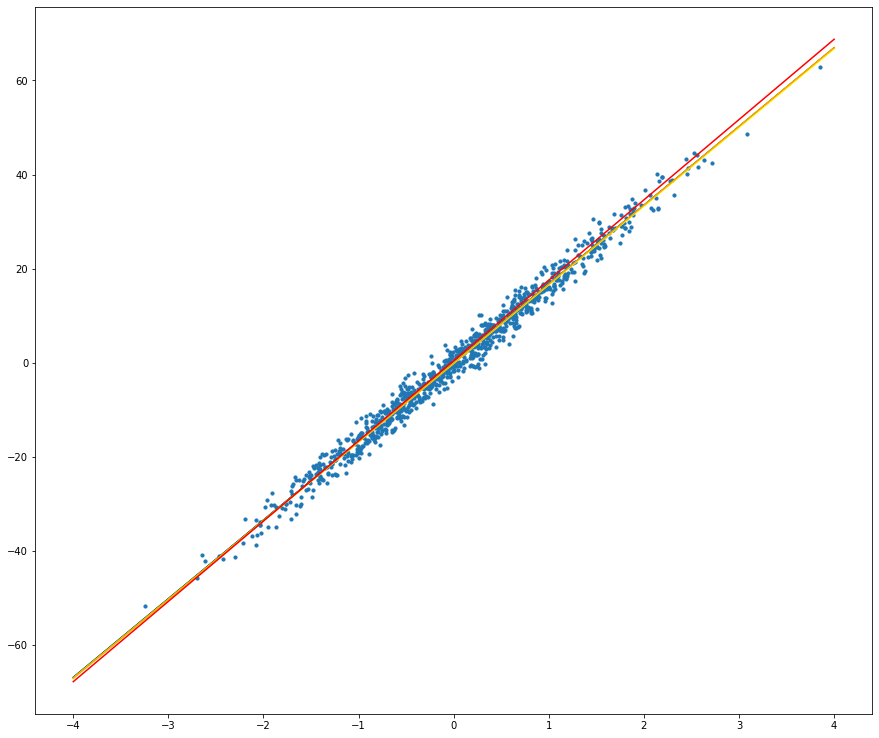

In [62]:
from re import S


lr = LinearRegression(fit_intercept=True)
lr1 = LinearRegression(fit_intercept=True)
lr2 = LinearRegression(fit_intercept=True)
lr3 = LinearRegression(fit_intercept=True)
lr4 = LinearRegression(fit_intercept=True)

lr.fit(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))
lr1.fit(np.array(df1.feature_1).reshape(-1,1),np.array(df1.target).reshape(-1,1))
lr2.fit(np.array(df2.feature_1).reshape(-1,1),np.array(df2.target).reshape(-1,1))
lr3.fit(np.array(df3.feature_1).reshape(-1,1),np.array(df3.target).reshape(-1,1))
lr4.fit(np.array(df4.feature_1).reshape(-1,1),np.array(df4.target).reshape(-1,1))

xspace = np.linspace(-4,4,1000)

yhat=lr.predict(xspace.reshape(1000,1))
yhat_1=lr1.predict(xspace.reshape(1000,1))
yhat_2=lr2.predict(xspace.reshape(1000,1))
yhat_3=lr3.predict(xspace.reshape(1000,1))
yhat_4=lr4.predict(xspace.reshape(1000,1))

f ,ax = plt.subplots(figsize=(15,13))
ax.scatter(df.feature_1,df.target,s=10)
ax.plot(xspace,yhat, color='blue')
ax.plot(xspace,yhat_1, color='green')
ax.plot(xspace,yhat_2, color='yellow')
ax.plot(xspace,yhat_3, color='orange')
ax.plot(xspace,yhat_4, color='red')

In [63]:
print(lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1)))
print(lr1.score(np.array(df1.feature_1).reshape(-1,1),np.array(df1.target).reshape(-1,1)))
print(lr2.score(np.array(df2.feature_1).reshape(-1,1),np.array(df2.target).reshape(-1,1)))
print(lr3.score(np.array(df3.feature_1).reshape(-1,1),np.array(df3.target).reshape(-1,1)))
print(lr2.score(np.array(df4.feature_1).reshape(-1,1),np.array(df4.target).reshape(-1,1)))

0.9855792900364626
0.9205931172113309
0.8247854752485749
0.4728704160822177
0.17625225794806498


Se probaron con diferentes porcentajes de valores imputados (5, 20, 50 y 80%) y si bien existen diferencias entre las rectas de regresión para cada dataframe (alejándose cada vez más de la regresión hecha con el dataframe original), gráficamente no son muy significativas. Sin embargo se ve una caída notable en el score de estas regresiones al aumentar la cantidad de valores imputados.

## Ejercicio 4

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

## Ejercicio 5

Generar ahora valores extremos utilizando `extreme_outliers`. ¿Cómo afecta esto a la regresión? ¿Se observa algo interesante?


<AxesSubplot:xlabel='feature_1', ylabel='target'>

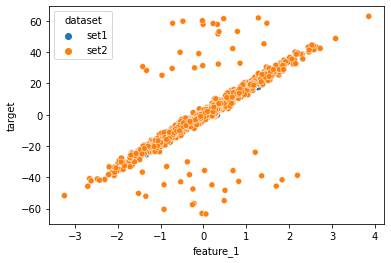

In [53]:
df_o = generate_outliers(df,['target'], percentage = 0.05, extreme_outlier = True)
#df_o = generate_outliers(df,['target'], percentage = 0.25, extreme_outlier = True)

X_train, X_val, X_test, Y_train, Y_val, Y_test = split(df, 0.7, 0.2, 0.1, 1)
X_train_o, X_val_o, X_test_o, Y_train_o, Y_val_o, Y_test_o = split(df_o, 0.7, 0.2, 0.1, 1)

sns.scatterplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_o.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset') 

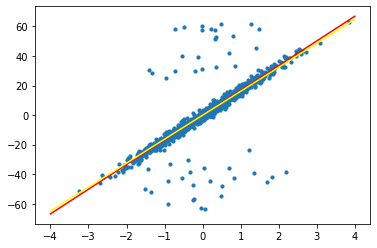

0.9855792900364626
0.6836919779987737


In [64]:
lr = LinearRegression(fit_intercept=True)
lr_o = LinearRegression(fit_intercept=True)
lr.fit(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))
lr_o.fit(np.array(df_o.feature_1).reshape(-1,1),np.array(df_o.target).reshape(-1,1))

xspace = np.linspace(-4,4,1000)
yhat=lr.predict(xspace.reshape(1000,1))
yhat_o=lr_o.predict(xspace.reshape(1000,1))

f ,ax = plt.subplots()
ax.scatter(df_o.feature_1,df_o.target,s=10)
ax.plot(xspace,yhat, color='red')
ax.plot(xspace,yhat_o, color='yellow')
plt.show()
print(lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1)))
print(lr_o.score(np.array(df_o.feature_1).reshape(-1,1),np.array(df_o.target).reshape(-1,1)))

Al agregar outliers extremos la Regresión y su score se ven afectados de mayor manera según el porcentaje de outliers que se agreguen

## Ejercicio 6

utilizando el archivo CSV `clase3v2.csv`, vamos a cargarlo como dataframe y deberemos:
 - Generar splits de training/test
 - Limpiar/Imputar datos Nulos
 - Entrenar un modelo de regresión multivariada
 - Reportar $R^2$ en test.

In [66]:
data_happiness = pd.read_csv('clase3v2.csv', delimiter = ';')

In [67]:
data_happiness.isna().sum()

feature_1        0
feature_2        0
feature_3       25
feature_4        0
feature_5       15
feature_6        0
target_value     0
dtype: int64

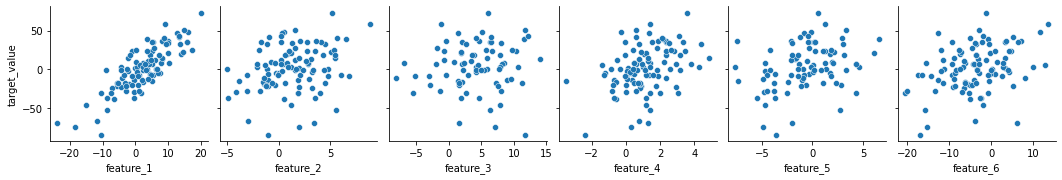

In [68]:
sns.pairplot(data_happiness,x_vars=["feature_1","feature_2","feature_3","feature_4","feature_5","feature_6"],y_vars='target_value')
plt.show()

In [69]:
nan_rows = data_happiness[data_happiness.isna().any(1)]
nan_rows

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target_value
0,3.669506,2.863605,NaN,2.948632,NaN,-9.364512,7.564543
1,13.505001,4.482330,NaN,0.770769,NaN,-3.706287,32.866898
2,-5.736774,-1.030994,NaN,0.907981,NaN,5.332656,-20.922094
3,-0.019325,1.909841,NaN,0.137427,NaN,3.400036,1.433380
4,6.079670,1.528345,NaN,0.746475,NaN,-11.486688,11.867943
5,-6.563463,0.476897,NaN,-0.576820,NaN,-5.003375,-37.913852
6,-7.113890,3.163686,NaN,0.832526,NaN,-6.500592,-23.741118
7,-0.460477,1.811576,NaN,-0.687152,NaN,-12.717867,-14.039603
8,-4.434366,1.919696,NaN,2.913292,NaN,-9.078455,-23.122893
9,-7.419374,4.003187,NaN,1.961815,NaN,-5.161921,-30.392307


In [70]:
X_train, X_test, Y_train, Y_test = split(data_happiness, 0.8, 0, 0.2, 6)

In [71]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_train

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
35,4.031313,-2.081522,8.138464,0.589899,4.300039,-4.069205,7.588145
75,3.711264,2.883610,9.639910,0.072790,-4.931949,-8.884144,-11.652328
19,13.779227,0.797328,NaN,1.050136,1.730029,-7.487210,20.165501
14,-11.799676,-2.961813,NaN,0.779812,NaN,-3.846574,-66.928472
98,7.060369,4.293074,3.590226,-0.066123,-2.039099,-3.643987,18.831133
...,...,...,...,...,...,...,...
15,4.375432,-0.119966,NaN,0.043858,-0.347020,0.880032,-6.119577
0,3.669506,2.863605,NaN,2.948632,NaN,-9.364512,7.564543
57,0.359445,3.218704,4.231046,0.244294,0.017648,4.255268,-3.373316
9,-7.419374,4.003187,NaN,1.961815,NaN,-5.161921,-30.392307


Elimino las filas donde tengo más de un NaN

In [72]:
df_train = df_train.dropna(thresh=6)
nan_rows = df_train[df_train.isna().any(1)]
nan_rows

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
19,13.779227,0.797328,NaN,1.050136,1.730029,-7.487210,20.165501
16,3.677814,-5.059008,NaN,-0.339200,-0.905344,0.267167,-0.027864
24,5.299924,4.069708,NaN,2.339350,-0.341389,3.438438,35.166792
17,0.980800,6.037507,NaN,1.356027,-0.871009,-9.340529,-7.221765
22,0.598013,-1.030075,NaN,0.490533,-3.662214,-0.366133,-5.778775
21,-2.381354,0.275137,NaN,0.040952,-4.664043,-11.818938,-2.417554
23,-0.491433,-4.209465,NaN,0.024498,-4.825984,-7.016355,-28.965822
18,5.413667,2.046161,NaN,1.192531,-0.831636,-17.361673,-7.286225
20,6.959910,-0.023091,NaN,0.276465,1.729196,-8.667381,-4.605250
15,4.375432,-0.119966,NaN,0.043858,-0.347020,0.880032,-6.119577


In [73]:
X_train = pd.concat([df_train.feature_1, df_train.feature_2, df_train.feature_3, df_train.feature_4, df_train.feature_5, df_train.feature_6], axis=1)
Y_train = df_train.target

Las filas con un NaN reemplazo por la media de ese feature

In [74]:
X_train = mean_imputer(X_train, "feature_3")
X_train.isna().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
dtype: int64

In [75]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train,Y_train)
lr.coef_, lr.score(X_train,Y_train), lr.intercept_

(array([ 3.05755026,  1.32164539,  0.32502674,  5.61908352, -0.08408363,
         1.20489546]),
 0.9200877297333651,
 -9.743663228042596)

In [76]:
df_test = pd.concat([X_test, Y_test], axis=1)
df_test = df_test.dropna()
X_test = pd.concat([df_test.feature_1, df_test.feature_2, df_test.feature_3, df_test.feature_4, df_test.feature_5, df_test.feature_6], axis=1)
Y_test = df_test.target 

In [78]:
lr.score(X_test, Y_test)

0.8451228732879387

\begin{equation}

    \begin{array}{rcl}
        \text{Target} &=& -10.576 +
                                3.016 \cdot \text{feature1} +
                                1.309 \cdot \text{feature2} -
                                0.327 \cdot \text{feature3} +
                                5.209 \cdot \text{feature4} - \\
                            & & 0.412 \cdot \text{feature5} +
                                1.027 \cdot \text{feature6} 
                                
    \end{array}
\end{equation}

## Ejercicio 7

Por último, manteniendo un dataset limpio como el que generamos previo al ejercio 1, utilizando `make_regression` de `scikit-learn`. Analizar que pasa si comenzamos a modificar el parametro `noise`

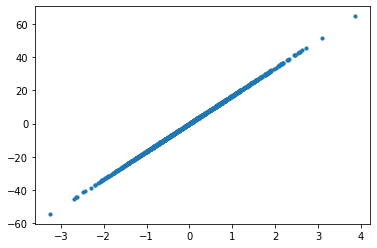

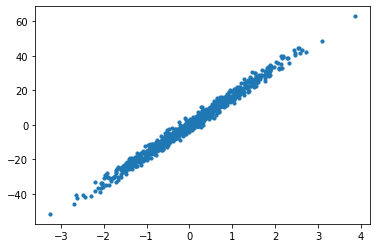

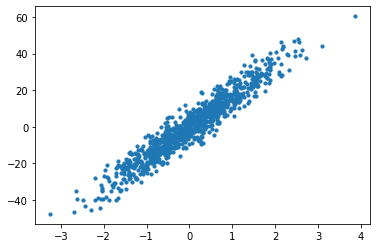

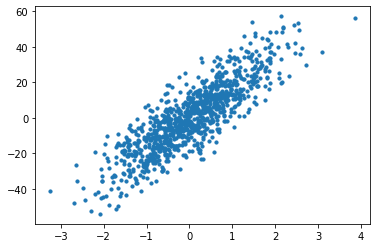

In [80]:
# Creamos un dataset de prueba
X0, y0 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 0,
                       n_informative = 1,
                       random_state = 42)

X2, y2 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

X5, y5 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 5,
                       n_informative = 1,
                       random_state = 42)

X10, y10 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 10,
                       n_informative = 1,
                       random_state = 42)
dfs = [pd.DataFrame(np.append(X0,y0.reshape(-1,1),axis=1)),
        pd.DataFrame(np.append(X2,y2.reshape(-1,1),axis=1)),
        pd.DataFrame(np.append(X5,y5.reshape(-1,1),axis=1)),
        pd.DataFrame(np.append(X10,y10.reshape(-1,1),axis=1))]

for df in dfs:

    new_col = []
    i = 0
    for col in df.columns:
        if i ==  len(df.columns) - 1:
            new_col.append("target")
        else :
            new_col.append("feature_" + str(i+1))
            
        i += 1
        
    df.columns = new_col
    f ,ax = plt.subplots()
    ax.scatter(df.feature_1,df.target,s=10)



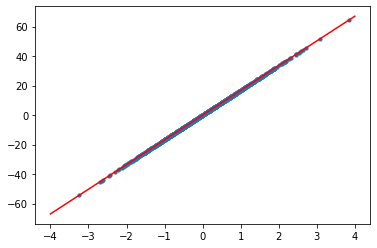

b0 = [[16.74825823]] ; score = 1.0


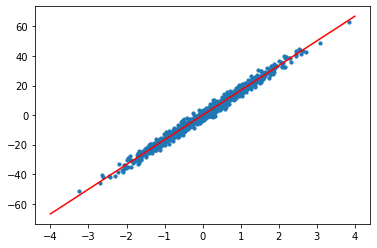

b0 = [[16.72531579]] ; score = 0.9855792900364626


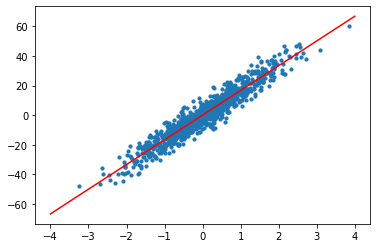

b0 = [[16.69090214]] ; score = 0.9158971293727719


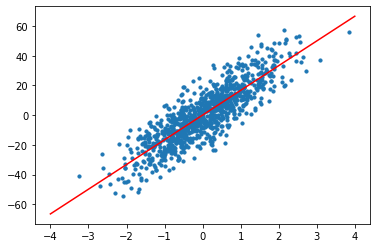

b0 = [[16.63354605]] ; score = 0.7300121896115735


In [81]:

for df in dfs:
    lr =LinearRegression(fit_intercept=True)
    lr.fit(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))
    f ,ax = plt.subplots()
    ax.scatter(df.feature_1,df.target,s=10)
    ax.plot(np.linspace(-4,4,1000),lr.predict(xspace.reshape(1000,1)), color='red')
    plt.show()
    print("b0 = {} ; score = {}".format(lr.coef_, lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))))


Conclusones:
Se agrega ruido gaussiano, afectando mínimamente el valor de los coeficientes de la regresión, pero con mayor peso en el coeficiente de determinación.

# Segunda parte


## Ejercicio 8

Vamos a tomar dos dataframes creados uno en el ejercicio 4 y otro del 5, utilizando el modelo `HuberRegressor` en `linear_model` de `scikit-learn`. Vamos a entrenar dos modelos robustos, el modelo mejora?

***Nota:*** Utilizar los valores por defecto del modelo

## Ejercicio 9 (Opcional)

Utilizando este esta funcion de Gradiente descendente de como idea, codear su implementación de Sthocastic Gradient Descent (SGD)

```python

def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x - y
    return res.mean(), (res * x).mean()

def gradient_descent(
    x: list,
    y: list,
    start: list,
    learn_rate: float = 0.1,
    n_iter: int = 50,
    tolerance: float =1e-06
):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * np.array(ssr_gradient(x, y, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector
```

# Tercera Parte

Vamos a crear un nuevo dataset, para ello vamos a usar el metodo `make_classification` de `sklearn`

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

X, y = make_classification(
    n_samples = 1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_classes=2,
    n_clusters_per_class=1
)

## Ejercicio 10

Con el dataset creado para clasficación vamos a utilizar el modelo `LogisticRegression`. Vamos a entrenar modelos variando los parámetros en particular `tol` y `max_iter`.
¿Cómo cambian estas regresiones?


## Ejercicio 11

Vamos a utilizar ahora el dataset de [iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Utilizando `LogisticRegression` vamos a realizar un clasificador multiclases.
¿Cómo se compara con el modelo de `Perceptron`?

In [ ]:
from sklearn.datasets import load_iris
X,y = load_iris(return_X_y=True, as_frame=True)

HINT: La clase perceptron la pueden utilizar así

```python
from sklearn.linear_model import Perceptron
X, y = load_iris(return_X_y=True, as_frame=True)
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)

clf.score(X, y)
```